In [1]:
import warnings
import src
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import segmentation_models_pytorch as smp
from pathlib import Path
import os 

warnings.filterwarnings("ignore")

/home/chia/miniconda3/envs/unet/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
model = smp.UnetSiamese(
    classes=4,
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    activation=None,
    decoder_attention_type="scse",
)

In [4]:
# Set device to GPU
device = torch.device("cuda")

model = smp.UnetSiamese(
    classes=4,  # Ensure this matches the trained model
    # encoder_name="efficientnet-b4",
    encoder_name="resnet34",

    encoder_weights="imagenet",
    activation=None,
    decoder_attention_type="scse",
)

# checkpoint_path = "/home/chia/bdd_multimodal-main/weights_unet/unetsiamese-efficientnet-b4_b6_e150_s200_bceloss_jaccardmccweighted.pth"
# checkpoint_path = "/home/chia/bdd_multimodal-main/weights_unet/unetsiamese-efficientnet-b4_b6_e200_s200_bceloss_jaccardmccweighted.pth"
# checkpoint_path = "/home/chia/bdd_multimodal-main/weights_unet/unetsiamese-efficientnet-b4_b6_e200_s200_bceloss_jaccardmccweighted.pth" #gan
checkpoint_path = "/home/chia/bdd_multimodal-main/weights_unet/unetsiamese-resnet34_b6_e200_s200_bceloss_jaccardmccweighted.pth"
checkpoint = torch.load(checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint["state_dict"])

model = model.to(device).eval()

print("Model loaded successfully and ready for inference!")



Model loaded successfully and ready for inference!


In [12]:
# dataset = "val"
dataset = "test"

# data_dir = f"/home/chia/bdd_multimodal-main/BDD_dataset{dataset}"
data_dir = f"/home/chia/bdd_multimodal-main/BDD_dataset_GAN/{dataset}"
fn_list = [f for f in Path(data_dir).rglob("*.tif") if "post_disaster" in str(f)]

# fn_list = [f for f in Path(data_dir).rglob("*.tif") if "post-event" in str(f)]

print(f"Making predictions on {len(fn_list)} samples, using {dataset}")

Making predictions on 118 samples, using test


Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00068_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00037_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/haiti-earthquake_00003_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00185_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00049_post_disaster_sar.tif


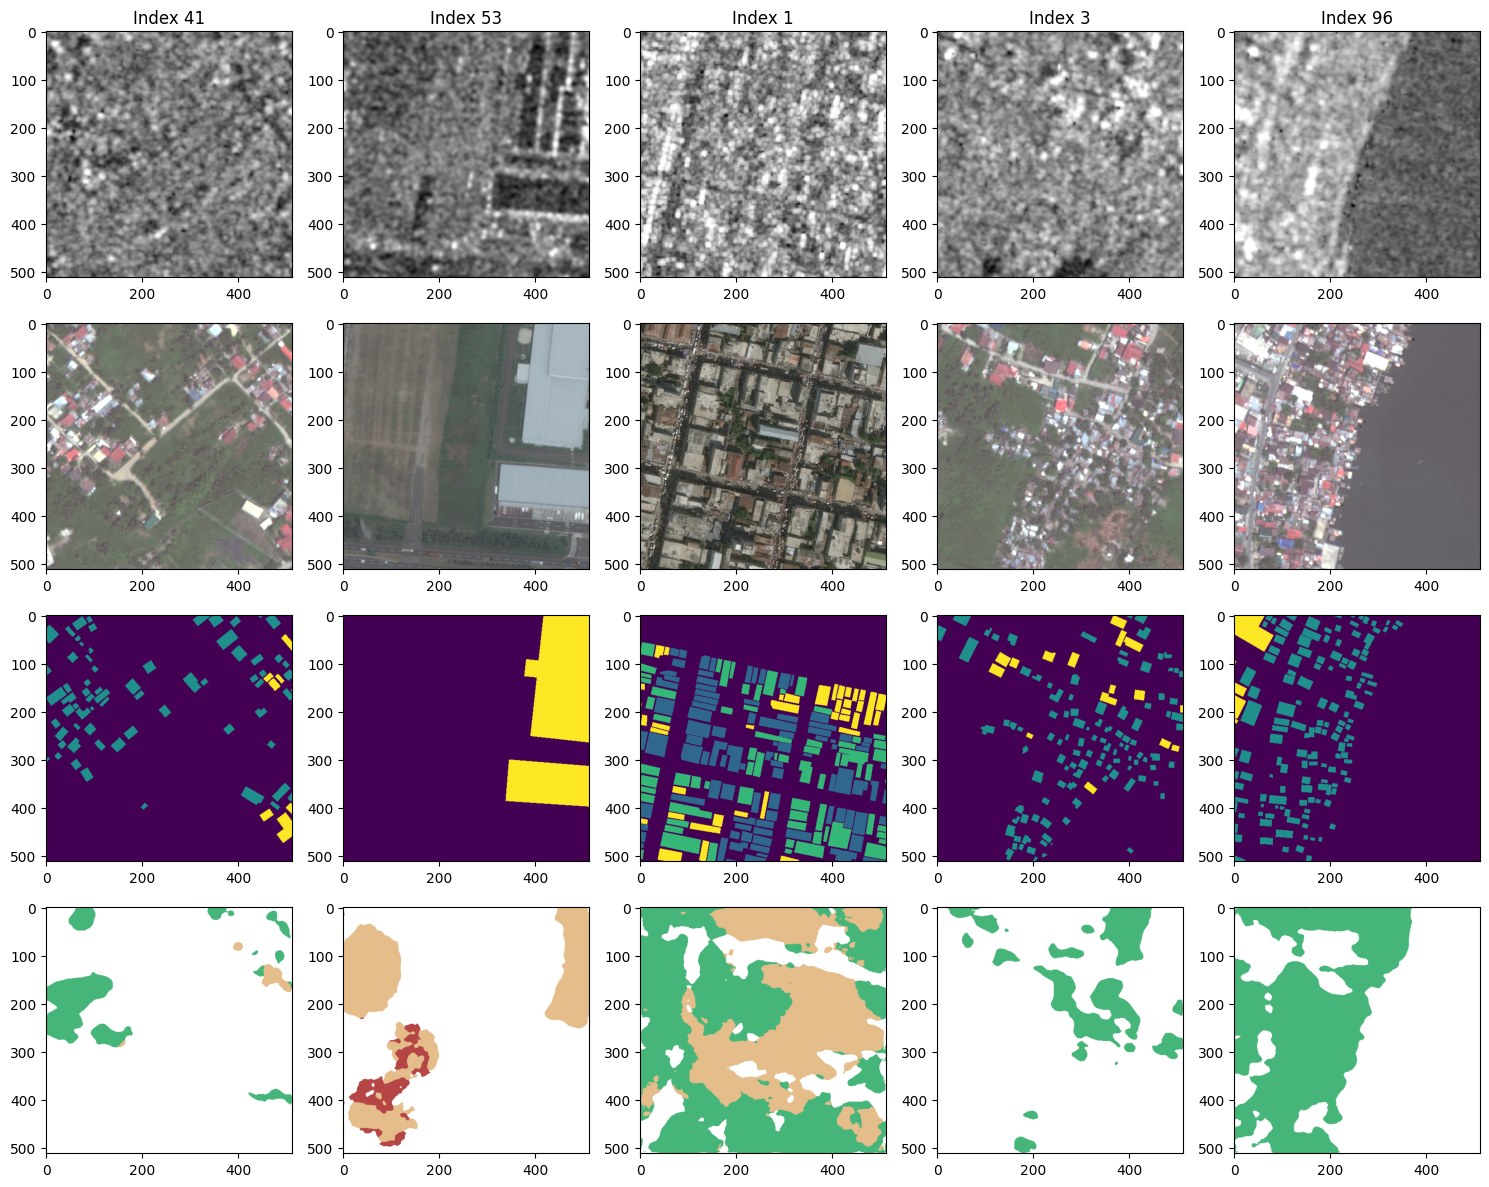

In [82]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import src.dataset   # Assuming your dataset functions are here
import src.tools     # For make_rgb or similar functions

# Number of samples to plot
nplot = 5
# Randomly select nplot indices
idxs = np.random.choice(len(fn_list), nplot, replace=False)
fig, axs = plt.subplots(4, nplot, figsize=(nplot * 3, 4 * 3))

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using the same logic as in BDD3 ---
    # Load post-disaster SAR (grayscale)
    sar = src.dataset.load_grayscale(fn_list[idx])
    # Load pre-disaster Optical:
    optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_pre_disaster_sar.tif", "_pre_disaster.tif") ### optical
    optical = src.dataset.load_multiband(optical_path)
    # Load pre-disaster SAR:
    presar_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_post_disaster_sar", "_pre_disaster_sar")
    pre_sar = src.dataset.load_grayscale(presar_path)
    
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    
    # # (Optional) Load ground truth if available for visualization:
    # if dataset != "val":
    #     gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    #     gtd = src.dataset.load_grayscale(gtd_path)
    # else:
    #     gtd = np.zeros_like(sar)
    
    # --- Preprocess and Fuse ---
    # Convert SAR (post) to a 3-channel image
    sar_3ch = np.stack([sar, sar, sar], axis=-1)  # shape: (H, W, 3)
    # Assume optical is already a 3-channel image; if not, adjust accordingly.
    # Convert pre-disaster SAR to 3-channel:
    pre_sar_3ch = np.stack([pre_sar, pre_sar, pre_sar], axis=-1)
    # Fuse the two pre-disaster modalities by averaging
    fused_pre = (optical.astype(np.float32) + pre_sar_3ch.astype(np.float32)) / 2.0
    # Ensure the fused image is in the same range as the others.
    
    # Create a 6-channel image by concatenating post-disaster SAR and the fused pre-disaster image.
    # They should both be of shape (H, W, 3); concatenation along the channel axis (axis=-1) gives (H, W, 6)
    input_img = np.concatenate([sar_3ch, fused_pre], axis=-1)
    # Rearrange to channel-first order: (6, H, W)
    input_img = np.moveaxis(input_img, -1, 0) / 255.0  # normalize to [0, 1]
    
    # --- Test-Time Augmentation (Optional) ---
    # Here we create flipped versions for TTA
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())     # horizontal flip
    tta_imgs.append(input_img[:, ::-1, :].copy())     # vertical flip
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())    # both flips
    
    # Convert to torch tensors and stack into a batch
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        # Assuming your model returns two outputs: localization and segmentation;
        # Here we use the segmentation output (typically the second one)
        loc_out, seg_out = model(tensor)
        # Compute probabilities with softmax along the channel dimension
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        # Collect TTA predictions: For instance, assume the batch dimension corresponds to different flips.
        preds = []
        # If your TTA ordering is the same as above:
        preds.append(seg_prob[0])  # original
        preds.append(seg_prob[1][:, :, ::-1])  # reverse horizontal flip
        preds.append(seg_prob[2][:, ::-1, :])  # reverse vertical flip
        preds.append(seg_prob[3][:, ::-1, ::-1])  # reverse both
        
        # Average the predictions across TTA and then take the argmax to get class labels.
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # --- Plotting ---
    axs[0, i].set_title(f"Index {idx}")
    axs[0, i].imshow(sar, cmap="gray")
    axs[1, i].imshow(optical.astype(np.uint8))
    axs[2, i].imshow(gtd, cmap="viridis" )  # or use src.tools.make_rgb(gtd) if needed
    axs[3, i].imshow(src.tools.make_rgb(final_pred))  # visualize predicted segmentation map

plt.tight_layout()
plt.show()


In [8]:
sar

array([[195, 200, 210, ..., 199, 196, 194],
       [197, 202, 212, ..., 201, 198, 196],
       [201, 206, 215, ..., 206, 201, 199],
       ...,
       [151, 152, 153, ..., 182, 174, 170],
       [154, 155, 158, ..., 180, 172, 168],
       [155, 157, 160, ..., 179, 171, 167]], shape=(512, 512), dtype=uint8)

In [28]:
presar_path

'/home/chia/bdd_multimodal-main/BDD_dataset/val/pre_disaster/philippines-typhoon_00202_pre_disaster_sar.tif'

Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00153_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00078_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00244_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00205_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00275_post_disaster_sar.tif


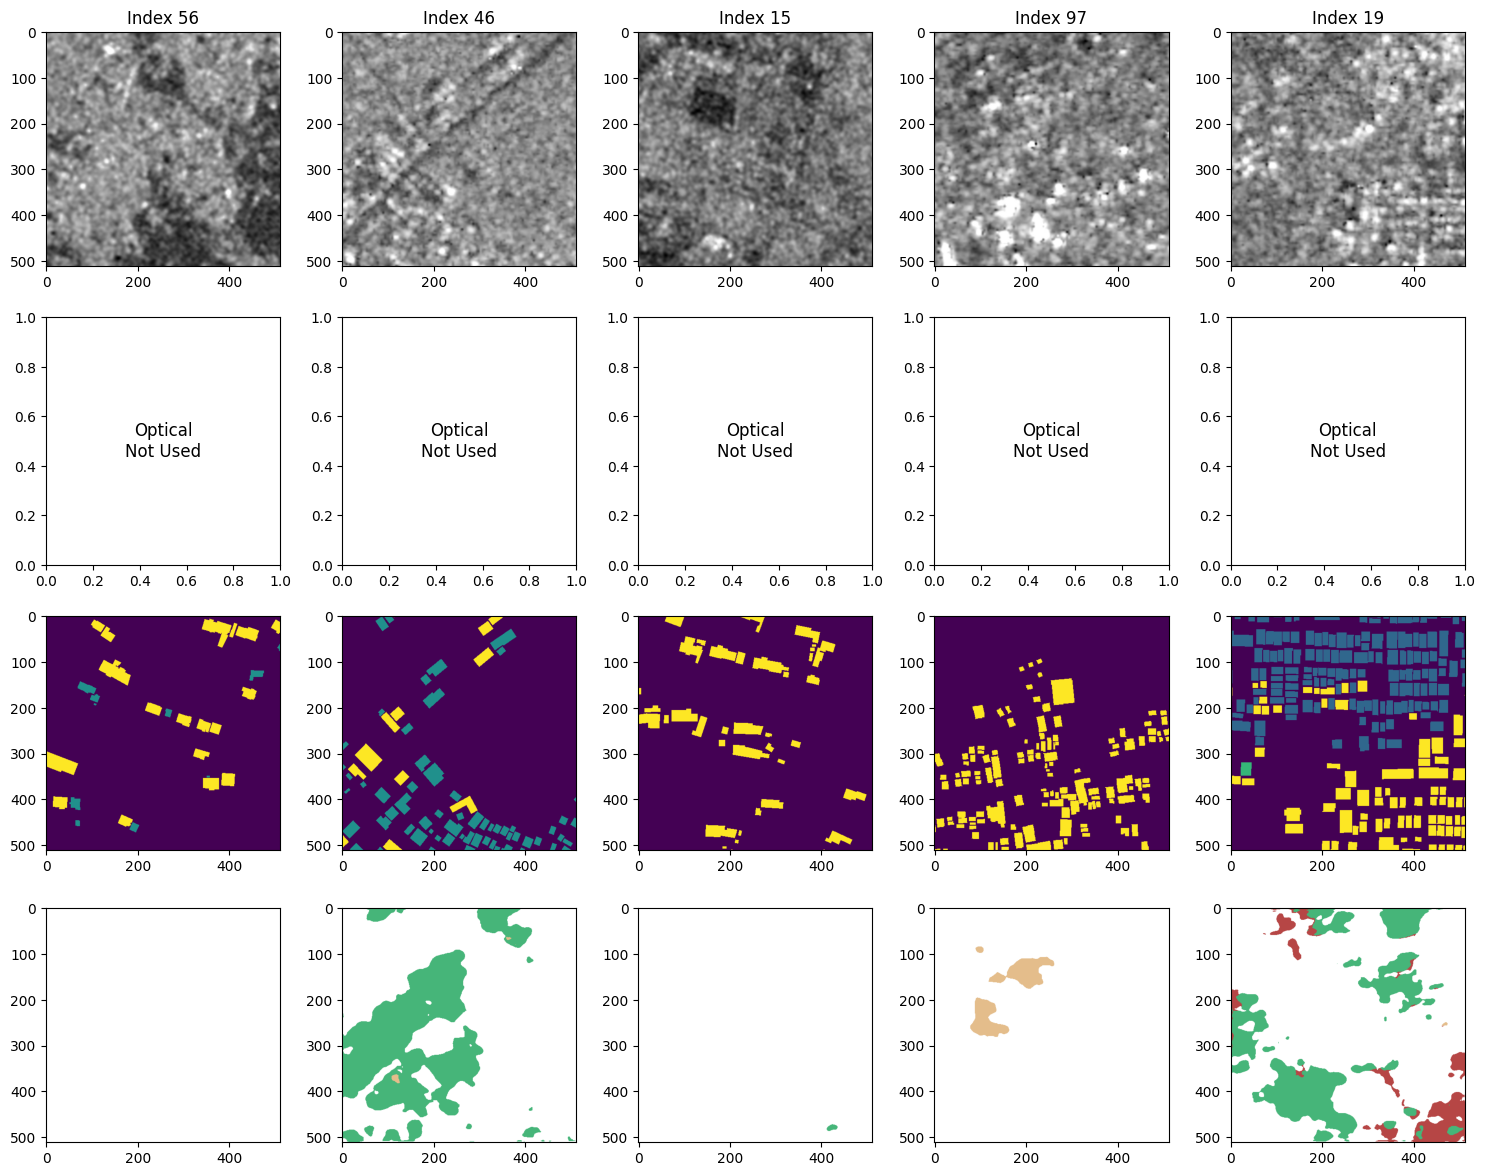

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import src.dataset   # For loading functions
import src.tools     # For make_rgb or similar functions

# Number of samples to plot
nplot = 5
# Randomly select nplot indices
idxs = np.random.choice(len(fn_list), nplot, replace=False)
fig, axs = plt.subplots(4, nplot, figsize=(nplot * 3, 4 * 3))

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using SAR only ---
    # Load post-disaster SAR (grayscale)
    sar = src.dataset.load_grayscale(fn_list[idx])
    
    # Load pre-disaster SAR:
    # Modify the path to get the pre-disaster SAR image:
    presar_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_post_disaster_sar", "_pre_disaster_sar")

    pre_sar = src.dataset.load_grayscale(presar_path)
    
    # (Optional) Load ground truth for visualization:
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    # --- Preprocess and Fuse ---
    # Convert the SAR images to 3-channel images
    sar_3ch = np.stack([sar, sar, sar], axis=-1)  # shape: (H, W, 3)
    pre_sar_3ch = np.stack([pre_sar, pre_sar, pre_sar], axis=-1)  # shape: (H, W, 3)
    
    # Fuse the pre-disaster SAR with the post-disaster SAR by concatenation
    input_img = np.concatenate([sar_3ch, pre_sar_3ch], axis=-1)  # shape: (H, W, 6)
    # Convert to channel-first order and normalize
    input_img = np.moveaxis(input_img, -1, 0) / 255.0  # shape: (6, H, W)
    
    # --- Test-Time Augmentation (TTA) ---
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())     # horizontal flip
    tta_imgs.append(input_img[:, ::-1, :].copy())     # vertical flip
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())    # both flips
    
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        # Assuming your model returns two outputs, here we use segmentation output
        loc_out, seg_out = model(tensor)
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        
        preds = []
        preds.append(seg_prob[0])            # original
        preds.append(seg_prob[1][:, :, ::-1])  # reverse horizontal flip
        preds.append(seg_prob[2][:, ::-1, :])  # reverse vertical flip
        preds.append(seg_prob[3][:, ::-1, ::-1])  # reverse both
        
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # --- Plotting ---
    axs[0, i].set_title(f"Index {idx}")
    axs[0, i].imshow(sar, cmap="gray")  # Post-disaster SAR (grayscale)
    # Optical is not used here, so you may leave row 2 blank or use it for other info.
    axs[1, i].text(0.5, 0.5, "Optical\nNot Used", ha="center", va="center", fontsize=12)
    axs[2, i].imshow(gtd, cmap="viridis")
    axs[3, i].imshow(src.tools.make_rgb(final_pred))

plt.tight_layout()
plt.show()



Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/palu-tsunami_00099_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/philippines-typhoon_00118_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/philippines-typhoon_00128_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/tohoku-tsunami_00032_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/tohoku-tsunami_00024_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/philippines-typhoon_00104_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/tohoku-tsunami_00018_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/post_disaster/palu-tsunami_00222_post_disaster_sar.tif
Processing: /home/chia/bdd_mu

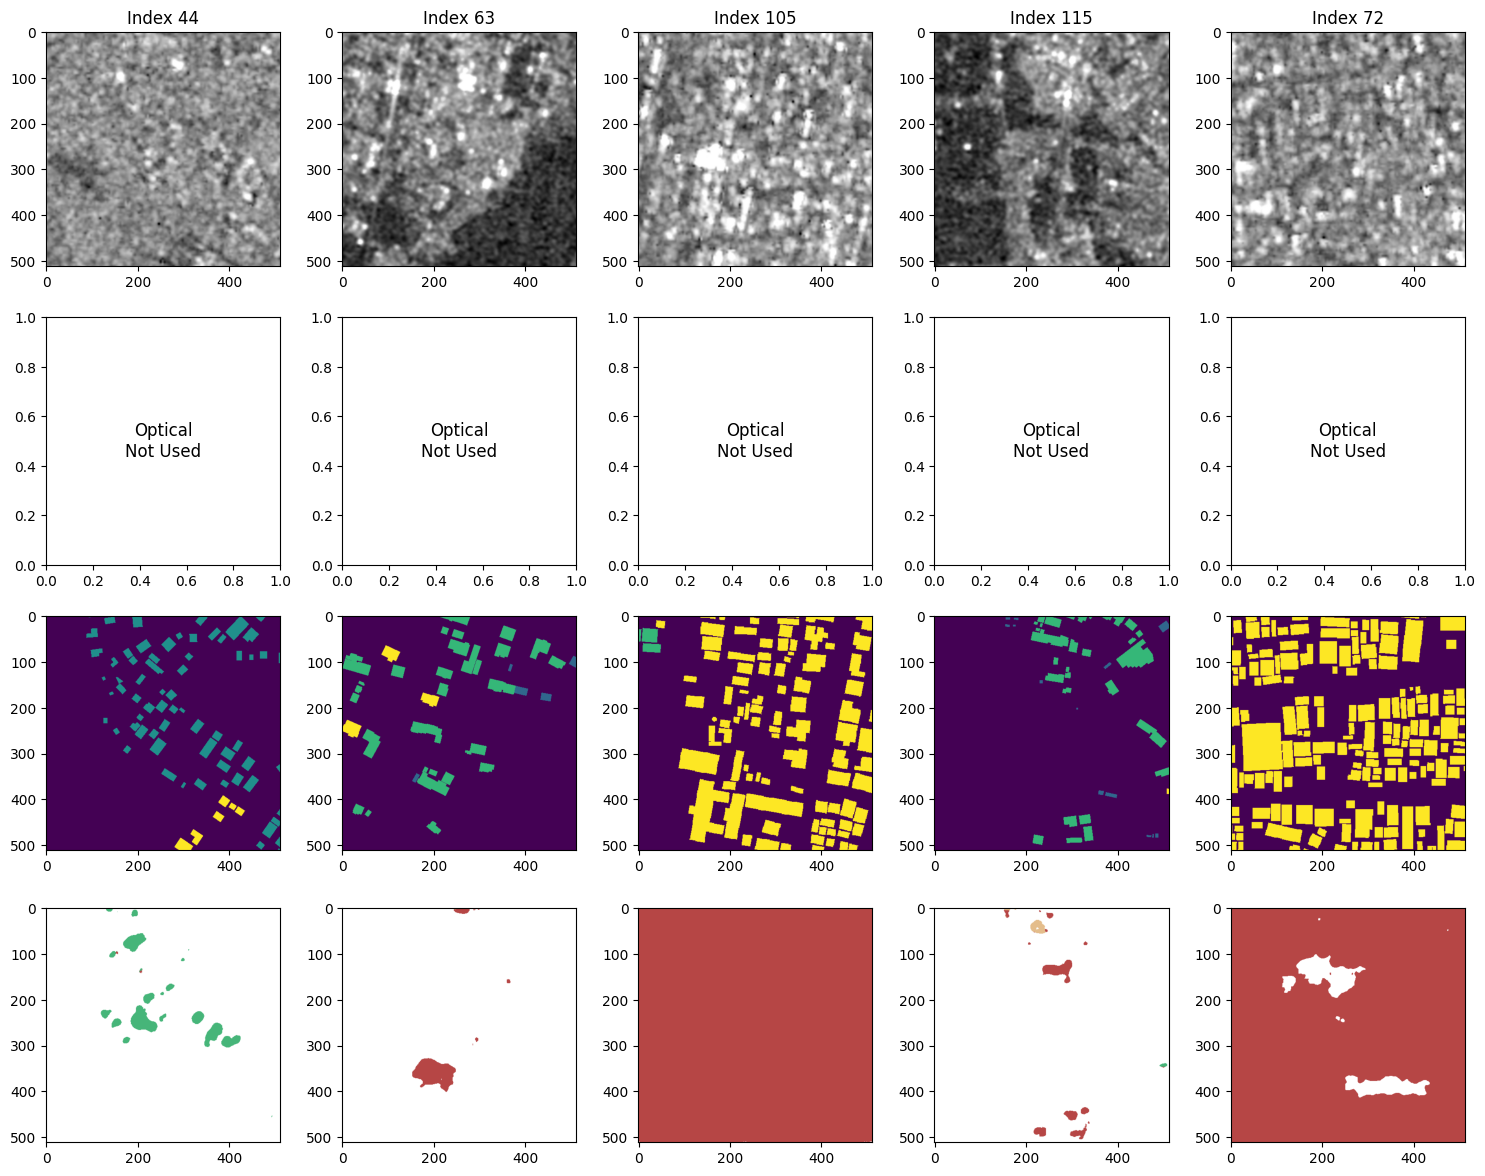

In [121]:
#testing on saving
predictions = []
indices = []

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # ... [your prediction code that computes final_pred] ...
    

nplot = 5
# Randomly select nplot indices
idxs = np.random.choice(len(fn_list), nplot, replace=False)
fig, axs = plt.subplots(4, nplot, figsize=(nplot * 3, 4 * 3))

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using SAR only ---
    # Load post-disaster SAR (grayscale)
    sar = src.dataset.load_grayscale(fn_list[idx])
    
    # Load pre-disaster SAR:
    # Modify the path to get the pre-disaster SAR image:
    presar_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_post_disaster_sar", "_pre_disaster_sar")

    pre_sar = src.dataset.load_grayscale(presar_path)
    
    # (Optional) Load ground truth for visualization:
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    # --- Preprocess and Fuse ---
    # Convert the SAR images to 3-channel images
    sar_3ch = np.stack([sar, sar, sar], axis=-1)  # shape: (H, W, 3)
    pre_sar_3ch = np.stack([pre_sar, pre_sar, pre_sar], axis=-1)  # shape: (H, W, 3)
    
    # Fuse the pre-disaster SAR with the post-disaster SAR by concatenation
    input_img = np.concatenate([sar_3ch, pre_sar_3ch], axis=-1)  # shape: (H, W, 6)
    # Convert to channel-first order and normalize
    input_img = np.moveaxis(input_img, -1, 0) / 255.0  # shape: (6, H, W)
    
    # --- Test-Time Augmentation (TTA) ---
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())     # horizontal flip
    tta_imgs.append(input_img[:, ::-1, :].copy())     # vertical flip
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())    # both flips
    
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        # Assuming your model returns two outputs, here we use segmentation output
        loc_out, seg_out = model(tensor)
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        
        preds = []
        preds.append(seg_prob[0])            # original
        preds.append(seg_prob[1][:, :, ::-1])  # reverse horizontal flip
        preds.append(seg_prob[2][:, ::-1, :])  # reverse vertical flip
        preds.append(seg_prob[3][:, ::-1, ::-1])  # reverse both
        
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # --- Plotting ---
    axs[0, i].set_title(f"Index {idx}")
    axs[0, i].imshow(sar, cmap="gray")  # Post-disaster SAR (grayscale)
    # Optical is not used here, so you may leave row 2 blank or use it for other info.
    axs[1, i].text(0.5, 0.5, "Optical\nNot Used", ha="center", va="center", fontsize=12)
    axs[2, i].imshow(gtd, cmap="viridis")
    axs[3, i].imshow(src.tools.make_rgb(final_pred))
    
    predictions.append(final_pred)
    indices.append(idx)
        

plt.tight_layout()
plt.show()





# Now save all predictions:
save_dir = "/home/chia/bdd_multimodal-main/predictions"
os.makedirs(save_dir, exist_ok=True)
for pred, idx in zip(predictions, indices):
    filename = os.path.join(save_dir, f"pred_{idx}.png")
    cv2.imwrite(filename, pred.astype(np.uint8))





Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00232_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/haiti-earthquake_00003_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00198_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00185_post_disaster_sar.tif


Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00026_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00202_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00165_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00192_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/philippines-typhoon_00193_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00112_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00053_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00055_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post

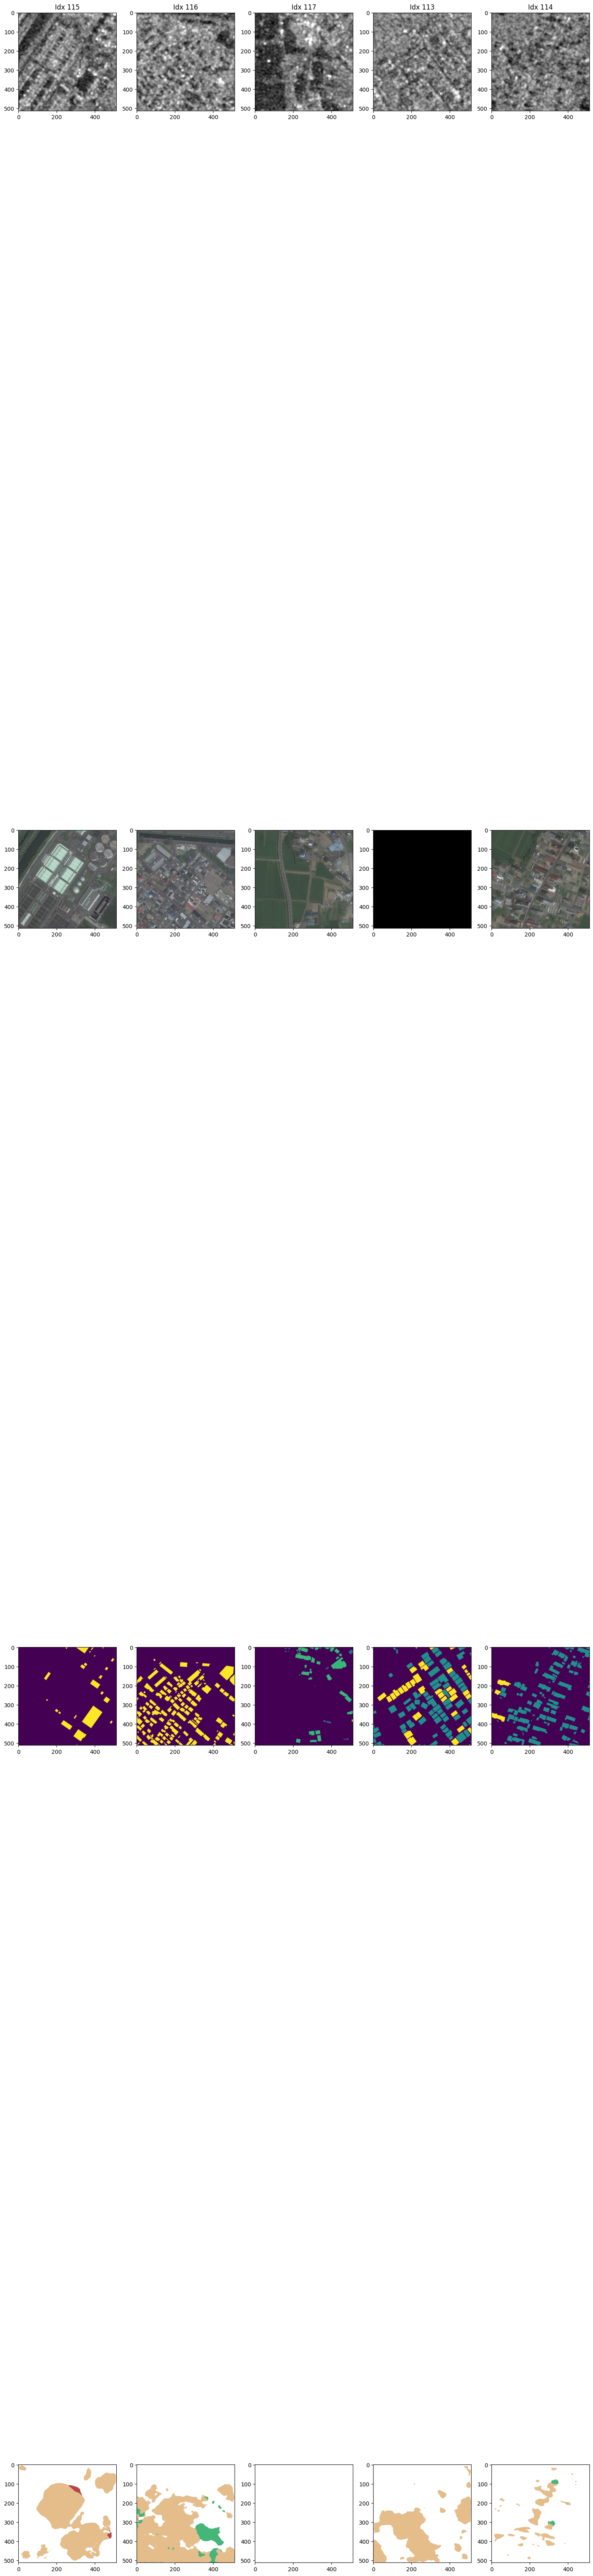

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import src.dataset   # For loading functions
import src.tools     # For make_rgb or similar functions
import os
import cv2

# Set to process all images:
nplot = len(fn_list)
idxs = np.arange(nplot)

# Create subplots dynamically if you want to display all images.
# Here we'll display a grid of images. Adjust the grid layout as needed.
ncols = 5  # number of images per row in the figure
nrows = int(np.ceil(nplot / ncols))
fig, axs = plt.subplots(4, ncols, figsize=(ncols * 3, 4 * nrows))

predictions = []  # List to store predictions for saving
indices = []      # List to store corresponding indices

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using SAR and Optical only ---
    # Load post-disaster SAR (grayscale)
    sar = src.dataset.load_grayscale(fn_list[idx])
    
    # Load pre-disaster Optical:
    optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_pre_disaster_sar.tif", "_pre_disaster.tif")
    optical = src.dataset.load_multiband(optical_path)
    
    # Load ground truth (if available) for visualization:
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    # --- Preprocess ---
    # Convert post-disaster SAR (grayscale) to 3-channel
    sar_3ch = np.stack([sar, sar, sar], axis=-1)  # shape: (H, W, 3)
    
    # Ensure optical image is 3-channel. If optical is single-channel, repeat it:
    if optical.shape[-1] == 1:
        optical = np.repeat(optical, 3, axis=-1)
    
    # For prediction, we use optical directly as the pre-disaster modality.
    fused_pre = optical.astype(np.float32)
    
    # Create a 6-channel image by concatenating the 3-channel SAR and the 3-channel optical
    input_img = np.concatenate([sar_3ch, fused_pre], axis=-1)  # shape: (H, W, 6)
    # Convert to channel-first format (6, H, W) and normalize to [0,1]
    input_img = np.moveaxis(input_img, -1, 0) / 255.0
    
    # --- Test-Time Augmentation (TTA) ---
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())     # horizontal flip
    tta_imgs.append(input_img[:, ::-1, :].copy())     # vertical flip
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())    # both flips
    
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        # Assuming your model returns two outputs: localization and segmentation;
        # Here we use the segmentation output (typically the second one)
        loc_out, seg_out = model(tensor)
        # Compute probabilities with softmax along the channel dimension
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        
        preds = []
        # Unflip predictions to original orientation:
        preds.append(seg_prob[0])            # original
        preds.append(seg_prob[1][:, :, ::-1])  # reverse horizontal flip
        preds.append(seg_prob[2][:, ::-1, :])  # reverse vertical flip
        preds.append(seg_prob[3][:, ::-1, ::-1])  # reverse both
        
        # Average the predictions across TTA and then take the argmax to get class labels.
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # Append the final prediction and index to our lists for saving later
    predictions.append(final_pred)
    indices.append(idx)
    
    # --- Plotting ---
    # Determine the column (i % ncols) and row for the current image
    col = i % ncols
    row_offset = (i // ncols)
    # Plot on the corresponding column in each row of the subplot grid:
    axs[0, col].set_title(f"Idx {idx}")
    axs[0, col].imshow(sar, cmap="gray")  # Post-disaster SAR (grayscale)
    axs[1, col].imshow(optical.astype(np.uint8))  # Optical image
    axs[2, col].imshow(gtd, cmap="viridis")  # Ground truth
    axs[3, col].imshow(src.tools.make_rgb(final_pred))  # Predicted segmentation map
    
    # Optionally, if there are more rows, create a new figure or adjust subplot indexing accordingly.

plt.tight_layout()
plt.show()

# --- Saving Predictions ---
save_dir = "/home/chia/bdd_multimodal-main/predictions"
os.makedirs(save_dir, exist_ok=True)
for pred, idx in zip(predictions, indices):
    filename = os.path.join(save_dir, f"pred_{idx}.png")
    cv2.imwrite(filename, pred.astype(np.uint8))


In [59]:
print("Unique classes in ground truth:", np.unique(gtd, return_counts=True))


Unique classes in ground truth: (array([0, 1, 2, 3], dtype=uint8), array([246798,   1130,  14157,     59]))


In [21]:
import numpy as np

def compute_iou_per_class(pred, target, num_classes, ignore_empty=True):
    """
    Compute the IoU for each class.

    Parameters:
      pred (np.array): Predicted segmentation map of shape (H, W) with class labels.
      target (np.array): Ground truth segmentation map of shape (H, W) with class labels.
      num_classes (int): The number of classes.
      ignore_empty (bool): If True, ignore classes with no ground truth pixels (union==0).

    Returns:
      iou_list (list): List of IoU values for each class.
    """
    iou_list = []
    for cls in range(num_classes):
        # Create binary masks for the current class
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        
        if union == 0:
            # If there are no pixels of this class in the ground truth and prediction,
            # you can choose to ignore this class in the average
            if ignore_empty:
                iou = np.nan
            else:
                iou = 1.0  # some consider it perfect if there is nothing to predict
        else:
            iou = intersection / union
        
        iou_list.append(iou)
    return iou_list

def compute_mean_iou(pred, target, num_classes, ignore_empty=True):
    """
    Compute the mean IoU over all classes.
    
    Returns:
      mean_iou (float): The mean IoU across classes.
      iou_list (list): The IoU for each class.
    """
    iou_list = compute_iou_per_class(pred, target, num_classes, ignore_empty)
    # Use np.nanmean to ignore classes with no pixels if ignore_empty is True.
    mean_iou = np.nanmean(iou_list)
    return mean_iou, iou_list

# Example usage:

num_classes = 4  # Adjust this to your number of classes
mean_iou, per_class_iou = compute_mean_iou(final_pred, gtd, num_classes, ignore_empty=True)
print("Mean IoU:", mean_iou)
print("Per-class IoU:", per_class_iou)


Mean IoU: 0.2353649139404297
Per-class IoU: [np.float64(0.9414596557617188), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/palu-tsunami_00082_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/haiti-earthquake_00015_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00043_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00082_post_disaster_sar.tif
Processing: /home/chia/bdd_multimodal-main/BDD_dataset/val/post_disaster/tohoku-tsunami_00244_post_disaster_sar.tif


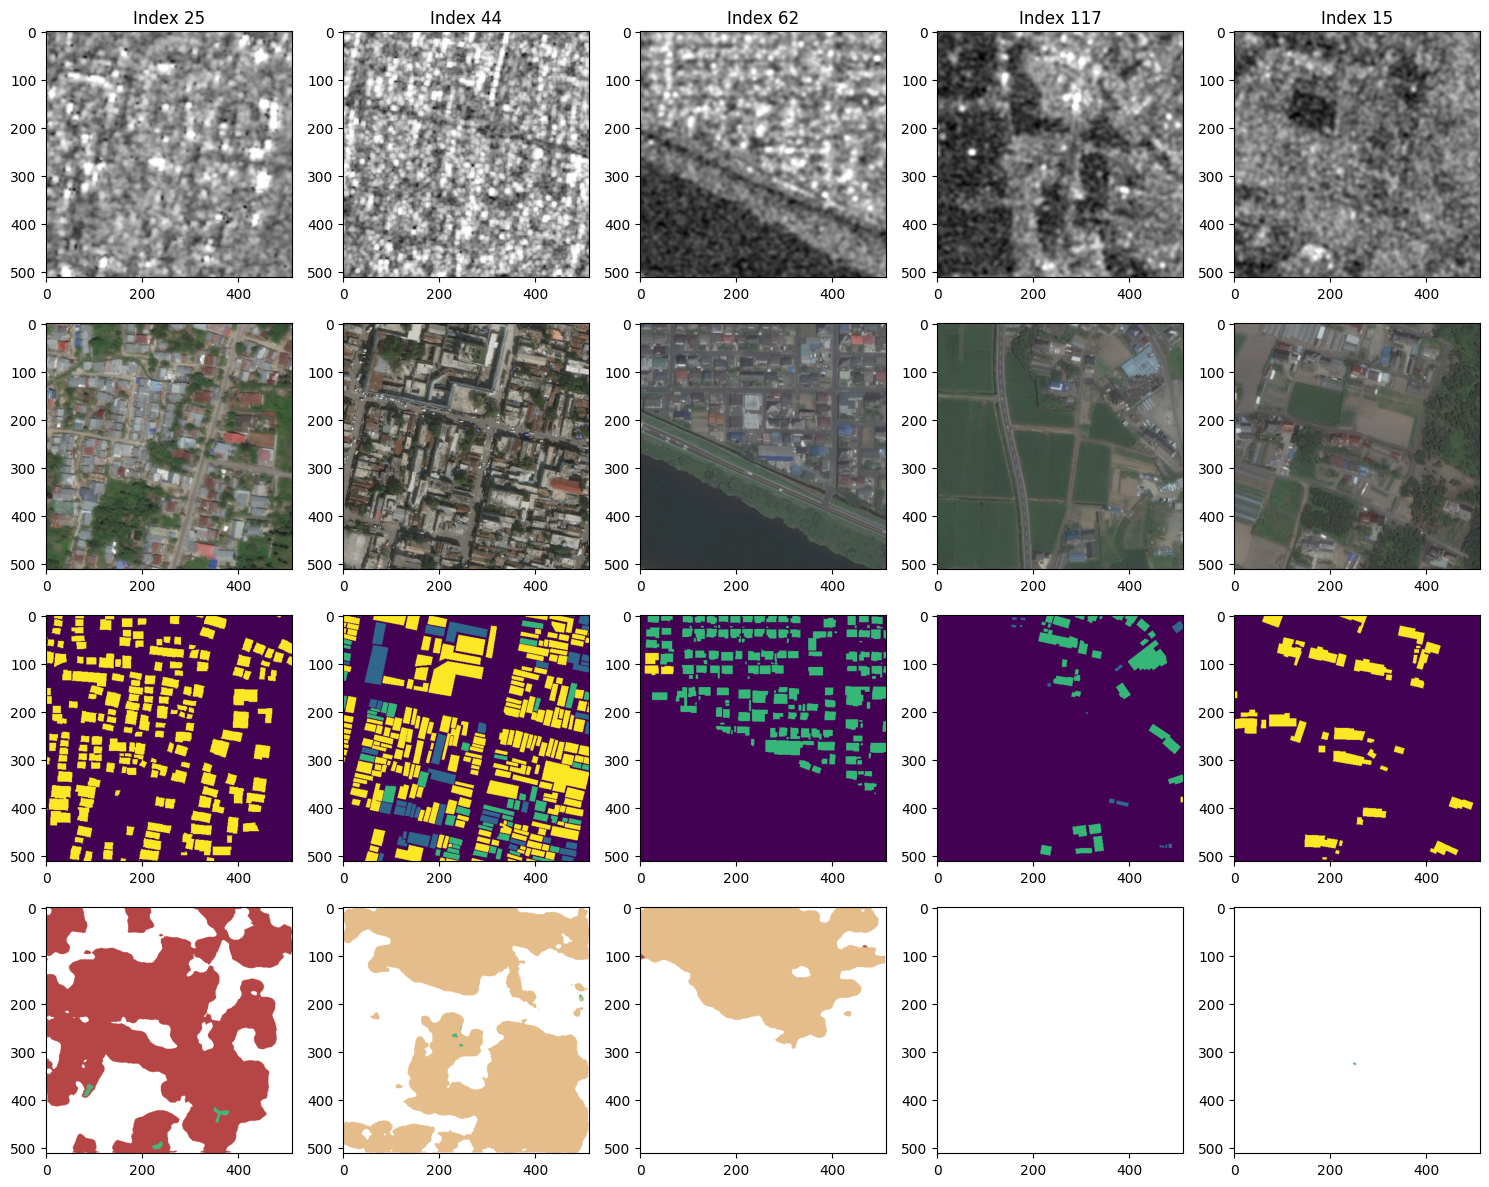

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import src.dataset   # For loading functions
import src.tools     # For make_rgb or similar functions

# Number of samples to plot
nplot = 5
# Randomly select nplot indices
idxs = np.random.choice(len(fn_list), nplot, replace=False)
fig, axs = plt.subplots(4, nplot, figsize=(nplot * 3, 4 * 3))

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using SAR and Optical only ---
    # Load post-disaster SAR (grayscale)
    sar = src.dataset.load_grayscale(fn_list[idx])
    
    # Load pre-disaster Optical:
    optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_pre_disaster_sar.tif", "_pre_disaster.tif") ### optical

    optical = src.dataset.load_multiband(optical_path)
    
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    # --- Preprocess ---
    # Convert post-disaster SAR (grayscale) to 3-channel
    sar_3ch = np.stack([sar, sar, sar], axis=-1)  # shape: (H, W, 3)
    
    # Ensure optical image is 3-channel. If optical is single-channel, repeat it:
    if optical.shape[-1] == 1:
        optical = np.repeat(optical, 3, axis=-1)
    # optical is now expected to be (H, W, 3)
    
    # For prediction, we use optical directly as the pre-disaster modality.
    fused_pre = optical.astype(np.float32)  # Here "fused_pre" is just the optical image.
    
    # Create a 6-channel image by concatenating the 3-channel SAR and the 3-channel optical
    input_img = np.concatenate([sar_3ch, fused_pre], axis=-1)  # shape: (H, W, 6)
    # Convert to channel-first format (6, H, W) and normalize to [0,1]
    input_img = np.moveaxis(input_img, -1, 0) / 255.0
    
    # --- Test-Time Augmentation (TTA) ---
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())     # horizontal flip
    tta_imgs.append(input_img[:, ::-1, :].copy())     # vertical flip
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())    # both flips
    
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        # Assuming your model returns two outputs: localization and segmentation;
        # Here we use the segmentation output (typically the second one)
        loc_out, seg_out = model(tensor)
        # Compute probabilities with softmax along the channel dimension
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        
        preds = []
        # Unflip predictions to original orientation:
        preds.append(seg_prob[0])            # original
        preds.append(seg_prob[1][:, :, ::-1])  # reverse horizontal flip
        preds.append(seg_prob[2][:, ::-1, :])  # reverse vertical flip
        preds.append(seg_prob[3][:, ::-1, ::-1])  # reverse both
        
        # Average the predictions across TTA and then take the argmax to get class labels.
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # --- Plotting ---
    axs[0, i].set_title(f"Index {idx}")
    axs[0, i].imshow(sar, cmap="gray")  # Post-disaster SAR (grayscale)
    axs[1, i].imshow(optical.astype(np.uint8))  # Optical image
    axs[2, i].imshow(gtd, cmap="viridis")  # Ground truth (if available)
    axs[3, i].imshow(src.tools.make_rgb(final_pred))  # Predicted segmentation map

plt.tight_layout()
plt.show()


In [44]:
def compute_iou(pred, target, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        
        if union == 0:
            iou = 1.0  # or 0.0, depending on your convention
        else:
            iou = intersection / union
        ious.append(iou)


        if union == 0:
            ious.append(np.nan)  # or 1.0 if you want to treat it as perfect
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

# In your evaluation loop:
with torch.no_grad():
    # Convert model output to predicted class labels (using argmax)
    pred = final_pred  # e.g., obtained via argmax from softmax probabilities
    iou_score = compute_iou(pred, gtd, num_classes=4)
    print("Mean IoU:", iou_score)


Mean IoU: 0.2353649139404297


In [119]:
def compute_iou_per_class(pred, target, num_classes):
    iou_list = []
    for c in range(num_classes):
        # Create binary masks for the class c
        pred_c = (pred == c)
        target_c = (target == c)
        intersection = np.logical_and(pred_c, target_c).sum()
        union = np.logical_or(pred_c, target_c).sum()
        if union == 0:
            iou = 1.0  # or 0.0, depending on your convention
        else:
            iou = intersection / union
        iou_list.append(iou)



    #     if union == 0:
    #         # If there are no pixels for class c in both prediction and target,
    #         # you might choose to ignore this class or consider its IoU as 1.
    #         iou = 1.0
    #     else:
    #         iou = intersection / union
    #     iou_list.append(iou)
    return iou_list

def compute_miou(pred, target, num_classes):
    iou_list = compute_iou_per_class(pred, target, num_classes)
    return np.mean(iou_list), iou_list

# Assume final_pred is your predicted segmentation of shape (H, W)
# and gtd is the corresponding ground truth segmentation of shape (H, W)
num_classes = 4  # or whatever number of classes your segmentation task uses
miou, iou_per_class = compute_miou(final_pred, gtd, num_classes)
print("Mean IoU:", miou)
print("IoU per class:", iou_per_class)


Mean IoU: 0.551627285519007
IoU per class: [np.float64(0.9405612961633316), np.float64(0.26594784591269655), np.float64(0.0), 1.0]


In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import src.dataset   # For loading functions
import src.tools     # For make_rgb or similar functions
import os
import cv2

# Define IoU functions as above
def compute_iou_per_class(pred, target, num_classes, ignore_empty=True):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        if union == 0:
            if ignore_empty:
                iou = np.nan
            else:
                iou = 1.0
        else:
            iou = intersection / union
        iou_list.append(iou)
    return iou_list

def compute_mean_iou(pred, target, num_classes, ignore_empty=True):
    iou_list = compute_iou_per_class(pred, target, num_classes, ignore_empty)
    mean_iou = np.nanmean(iou_list)
    return mean_iou, iou_list

# Process all images
nplot = len(fn_list)
idxs = np.arange(nplot)

predictions = []  # To store predictions for saving
indices = []      # To store corresponding indices
iou_scores = []   # To store mIoU per image
per_class_ious = []  # To store per-class IoU per image

num_classes = 4

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using SAR and Optical only ---
    sar = src.dataset.load_grayscale(fn_list[idx])
    # optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_pre_disaster_sar.tif", "_pre_disaster.tif") # optical
    optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_post_disaster_sar.tif", "_pre_disaster_sar.tif") #sar
    # optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster")

    optical = src.dataset.load_multiband(optical_path)
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    # --- Preprocess ---
    sar_3ch = np.stack([sar, sar, sar], axis=-1)
    if optical.shape[-1] == 1:
        optical = np.repeat(optical, 3, axis=-1)
    fused_pre = optical.astype(np.float32)  # Use optical only for pre-disaster in this case.
    
    input_img = np.concatenate([sar_3ch, fused_pre], axis=-1)
    input_img = np.moveaxis(input_img, -1, 0) / 255.0
    
    # --- Test-Time Augmentation (TTA) ---
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())
    tta_imgs.append(input_img[:, ::-1, :].copy())
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        loc_out, seg_out = model(tensor)
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        
        preds = []
        preds.append(seg_prob[0])
        preds.append(seg_prob[1][:, :, ::-1])
        preds.append(seg_prob[2][:, ::-1, :])
        preds.append(seg_prob[3][:, ::-1, ::-1])
        
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # --- Compute IoU for this image ---
    mean_iou, per_class_iou = compute_mean_iou(final_pred, gtd, num_classes, ignore_empty=True)
    print(f"Image {idx} - Mean IoU: {mean_iou:.3f}, Per-class IoU: {per_class_iou}")
    iou_scores.append(mean_iou)
    per_class_ious.append(per_class_iou)
    
    predictions.append(final_pred)
    indices.append(idx)
    
# Optionally, you can compute an overall mean IoU across all images:
overall_miou = np.nanmean(iou_scores)
print("Overall Mean IoU:", overall_miou)

# --- (Optional) Save predictions ---
save_dir = "/home/chia/bdd_multimodal-main/predictions"
os.makedirs(save_dir, exist_ok=True)
for pred, idx in zip(predictions, indices):
    filename = os.path.join(save_dir, f"pred_{idx}.png")
    cv2.imwrite(filename, pred.astype(np.uint8))


Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/test/post_disaster/philippines-typhoon_00213_post_disaster_sar.tif


TypeError: UnetSiamese.forward() missing 2 required positional arguments: 'sar_pre' and 'sar_post'

In [117]:
optical_path

'/home/chia/bdd_multimodal-main/BDD_dataset_GAN/val/pre_disaster/philippines-typhoon_00223_pre_disaster_sar.tif'

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import src.dataset   # For loading functions
import src.tools     # For make_rgb or similar functions
import os
import cv2

# Define IoU functions as above
def compute_iou_per_class(pred, target, num_classes, ignore_empty=True):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        if union == 0:
            if ignore_empty:
                iou = np.nan
            else:
                iou = 1.0
        else:
            iou = intersection / union
        iou_list.append(iou)
    return iou_list

def compute_mean_iou(pred, target, num_classes, ignore_empty=True):
    iou_list = compute_iou_per_class(pred, target, num_classes, ignore_empty)
    mean_iou = np.nanmean(iou_list)
    return mean_iou, iou_list

# Process all images
nplot = len(fn_list)
idxs = np.arange(nplot)

predictions = []  # To store predictions for saving
indices = []      # To store corresponding indices
iou_scores = []   # To store mIoU per image
per_class_ious = []  # To store per-class IoU per image

num_classes = 4

for i, idx in enumerate(idxs):
    print("Processing:", fn_list[idx])
    
    # --- Load the images using SAR and Optical only ---
    sar = src.dataset.load_grayscale(fn_list[idx])
    # optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_pre_disaster_sar.tif", "_pre_disaster.tif") # optical
    optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster").replace("_post_disaster_sar.tif", "_pre_disaster_sar.tif") #sar
    # optical_path = str(fn_list[idx]).replace("post_disaster", "pre_disaster")

    optical = src.dataset.load_multiband(optical_path)
    gtd_path = str(fn_list[idx]).replace("post_disaster", "target").replace("target", "building_damage").replace("_sar", "")
    gtd = src.dataset.load_grayscale(gtd_path)
    
    # --- Preprocess ---
    sar_3ch = np.stack([sar, sar, sar], axis=-1)
    if optical.shape[-1] == 1:
        optical = np.repeat(optical, 3, axis=-1)
    fused_pre = optical.astype(np.float32)  # Use optical only for pre-disaster in this case.
    
    input_img = np.concatenate([sar_3ch, fused_pre], axis=-1)
    input_img = np.moveaxis(input_img, -1, 0) / 255.0
    
    # --- Test-Time Augmentation (TTA) ---
    tta_imgs = []
    tta_imgs.append(input_img.copy())
    tta_imgs.append(input_img[:, :, ::-1].copy())
    tta_imgs.append(input_img[:, ::-1, :].copy())
    tta_imgs.append(input_img[:, ::-1, ::-1].copy())
    tensor = torch.cat([torch.from_numpy(x).unsqueeze(0) for x in tta_imgs], dim=0).float().to(device)
    
    # --- Model Inference ---
    model.eval()
    with torch.no_grad():
        loc_out, seg_out = model(tensor)
        seg_prob = torch.softmax(seg_out, dim=1).cpu().numpy()
        
        preds = []
        preds.append(seg_prob[0])
        preds.append(seg_prob[1][:, :, ::-1])
        preds.append(seg_prob[2][:, ::-1, :])
        preds.append(seg_prob[3][:, ::-1, ::-1])
        
        avg_pred = np.mean(np.stack(preds, axis=0), axis=0)
        final_pred = avg_pred.argmax(axis=0)  # shape: (H, W)
    
    # --- Compute IoU for this image ---
    mean_iou, per_class_iou = compute_mean_iou(final_pred, gtd, num_classes, ignore_empty=True)
    print(f"Image {idx} - Mean IoU: {mean_iou:.3f}, Per-class IoU: {per_class_iou}")
    iou_scores.append(mean_iou)
    per_class_ious.append(per_class_iou)
    
    predictions.append(final_pred)
    indices.append(idx)
    
# Optionally, you can compute an overall mean IoU across all images:
overall_miou = np.nanmean(iou_scores)
print("Overall Mean IoU:", overall_miou)

# --- (Optional) Save predictions ---
save_dir = "/home/chia/bdd_multimodal-main/predictions"
os.makedirs(save_dir, exist_ok=True)
for pred, idx in zip(predictions, indices):
    filename = os.path.join(save_dir, f"pred_{idx}.png")
    cv2.imwrite(filename, pred.astype(np.uint8))


Processing: /home/chia/bdd_multimodal-main/BDD_dataset_GAN/test/post_disaster/philippines-typhoon_00213_post_disaster_sar.tif


TypeError: UnetSiamese.forward() missing 2 required positional arguments: 'sar_pre' and 'sar_post'

TypeError: cannot unpack non-iterable PosixPath object